In [1]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy import linalg as la
from scipy import optimize
from scipy import stats
from scipy.stats import chisquare

import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
file = 'SouthCalifornia-1982-2011_Physics-of-Data.dat'
data = np.genfromtxt(file,
                     dtype=None,
                     delimiter=' ')
data.shape

(110271,)

In [3]:
df = pd.DataFrame(data)
df.columns = ['event', 'prev_event', 'time', 'magnitude', 'x', 'y', 'z']

# 0 - Understanding data

First of all we took a look at the dataset.

In [4]:
df.head()

,event,prev_event,time,magnitude,x,y,z
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546


In [5]:
# we can see that the range of magnitudes is [2,7.3] 
# and that the measurement of time starts from 0 with the first event
df.describe()

,event,prev_event,time,magnitude,x,y,z
count,110271.000000,110271.000000,1.102710e+05,110271.000000,1.102710e+05,1.102710e+05,1.102710e+05
mean,55135.000000,35859.277625,4.262426e+08,2.457920,-2.388225e+06,-4.691072e+06,3.562612e+06
std,31832.640104,36365.001297,2.598605e+08,0.438374,8.878019e+04,1.237294e+05,1.271897e+05
min,0.000000,-1.000000,0.000000e+00,2.000000,-2.770239e+06,-5.020849e+06,3.186133e+06
25%,27567.500000,-1.000000,2.115783e+08,2.140000,-2.421620e+06,-4.801152e+06,3.458838e+06
50%,55135.000000,28462.000000,3.551023e+08,2.340000,-2.361829e+06,-4.699729e+06,3.564367e+06
75%,82702.500000,66972.000000,5.952398e+08,2.640000,-2.329898e+06,-4.615062e+06,3.634552e+06
max,110270.000000,110250.000000,9.305667e+08,7.300000,-1.998294e+06,-4.268289e+06,3.876120e+06


In [6]:
# not all the greatest earthquakes are without ancestors (we shall call them 'prime events')
df[df['magnitude']>6].sort_values(by = 'magnitude', ascending = False)

,event,prev_event,time,magnitude,x,y,z
39805,39805,39804,3.309144e+08,7.30,-2341818,-4710335,3575181
100065,100065,100062,8.915162e+08,7.20,-2294542,-4855348,3390238
75422,75422,75419,5.612489e+08,7.10,-2316706,-4693410,3609984
58367,58367,-1,3.799916e+08,6.70,-2508327,-4610300,3567642
22089,22089,21867,1.859399e+08,6.60,-2322573,-4795291,3462353
89331,89331,-1,6.932159e+08,6.48,-2662869,-4420508,3708948
39859,39859,39858,3.309257e+08,6.30,-2373276,-4692488,3573922
21867,21867,21866,1.858990e+08,6.20,-2316585,-4796535,3470023
37455,37455,37449,3.251864e+08,6.10,-2335795,-4723356,3549940
55532,55532,-1,3.588626e+08,6.10,-2364815,-4481227,3839436


# 1 - Data visualization

## 1.1 - Time distribution

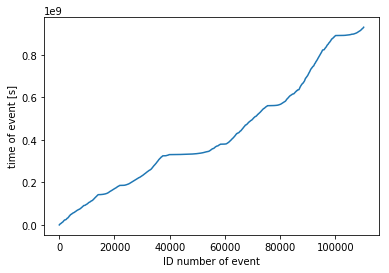

In [7]:
# just a routine look at the time distribution and time scale of the dataset 
%matplotlib inline

plt.plot(df['event'], df['time'])
plt.xlabel('ID number of event')
plt.ylabel('time of event [s]')
plt.show()

## 1.2 - Magnitude distribution

In [8]:
def my_expon(x, No, alpha):
    return No*np.exp(-alpha*x)

def my_log_expon(x, Q, alpha):
    return -alpha*x + Q

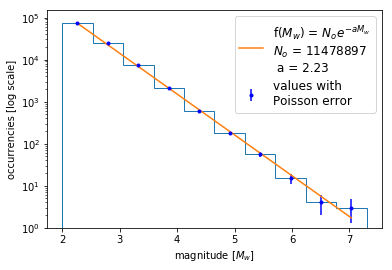

In [9]:
# here we can see how the magnitude is distributed as exp(-m)
n, bins, _ = plt.hist(df['magnitude'], log = True, histtype = 'step')
bin_centers = (bins[1:] + bins[:-1])/2
plt.errorbar(bin_centers, n, np.sqrt(n), fmt = '.b', label = 'values with \nPoisson error')

params1, _ = optimize.curve_fit(my_log_expon, bin_centers, np.log(n))
[Q, alpha] = params1
No = int(np.exp(Q))
plt.plot(bin_centers, my_expon(bin_centers, No, alpha), 
         label = 'f($M_w$) = $N_o$$e^{-aM_w}$ '+'\n$N_o$ = {}\n a = {}'.format(No,round(alpha,2)))

plt.xlabel('magnitude [$M_w$]')
plt.ylabel('occurrencies [log scale]')
plt.ylim(bottom = 1)
plt.legend(fontsize = 12)
plt.show()
plt.close()

## 1.3 - Spatial distribution 

In [10]:
from mpl_toolkits.mplot3d import Axes3D

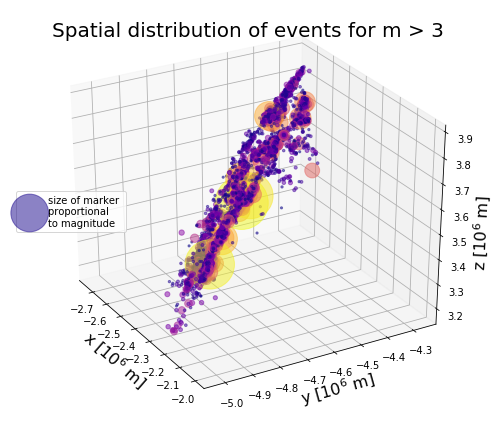

In [11]:
#az = [i*15 for i in range(24)]
#for azim in az:
#%matplotlib nbagg
m_bar = 3
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
magnitude = dfm['magnitude']

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coord/1e06, y_coord/1e06, z_coord/1e06, 
           s=np.exp(magnitude*1.5)/np.exp(3), c = magnitude, marker="o", alpha = 0.5, 
           label = 'size of marker \nproportional \nto magnitude', cmap = 'plasma')
ax.set_xlabel("x [$10^6$ m]", fontsize = 16)
ax.set_ylabel("y [$10^6$ m]", fontsize = 16)
ax.set_zlabel("z [$10^6$ m]", fontsize = 16)
ax.set_title('Spatial distribution of events for m > 3', fontsize = 20)
ax.legend(loc = 'center left')
#print('azim = ', azim)
ax.view_init(elev = 30, azim = 330)
plt.tight_layout()
plt.show()

### 1.3.1 PCA for spatial distribution

In [12]:
X = df[['x','y','z']].values.T
X = X.astype("float64")

# centering and rescaling the coordinates
for i in range(3):
    X[i] = (X[i] - X[i].mean())/X[i].std()

In [13]:
# PCA 
C = np.cov(X)
U, spectrum, Vt = la.svd(C)
print ('Spectrum: ', spectrum,'\n')
perc_expl2 = (spectrum[0] + spectrum[1]) / spectrum.sum()
print('Percent of the total variability explained considering the two main features: ', perc_expl2, '\n')

Spectrum:  [2.40189791e+00 5.96194962e-01 1.93433620e-03] 

Percent of the total variability explained considering the two main features:  0.9993552271146224 



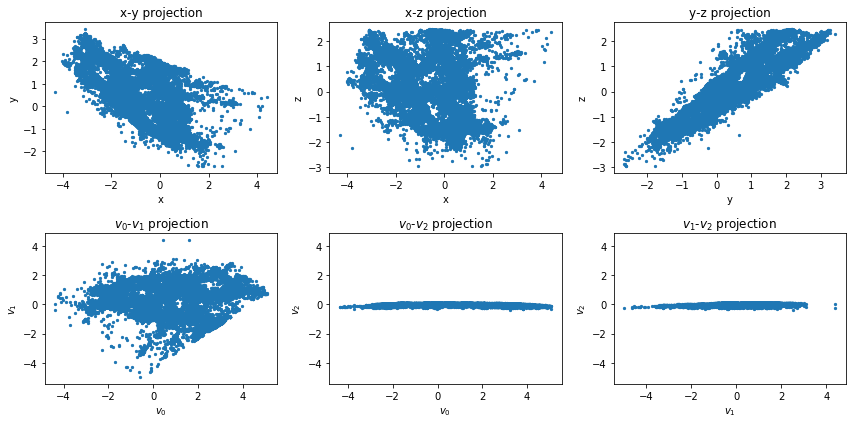

In [14]:
# projecting the data in the plane generated by the two eigenvectors with the largest eigenvalues
Xp = np.dot(Vt,X)

%matplotlib inline
# general plot of the PCA
fig, axes = plt.subplots(nrows=2, ncols=3,
                               figsize=(12, 6))

[[ax01, ax02, ax03],[ax11, ax12, ax13]] = axes

ax01.scatter(X[0], X[1], s= 5)
ax01.set_title('x-y projection')
ax01.set_xlabel('x')
ax01.set_ylabel('y')

ax02.scatter(X[0], X[2], s= 5)
ax02.set_title('x-z projection')
ax02.set_xlabel('x')
ax02.set_ylabel('z')

ax03.scatter(X[1], X[2], s= 5)
ax03.set_title('y-z projection')
ax03.set_xlabel('y')
ax03.set_ylabel('z')

ax11.scatter(Xp[0], Xp[1], s= 5)
ax11.set_title('$v_0$-$v_1$ projection')
(y_bottom, y_top) = ax11.get_ylim()
ax11.set_xlabel('$v_0$')
ax11.set_ylabel('$v_1$')

ax12.scatter(Xp[0], Xp[2], s= 5)
ax12.set_ylim(y_bottom, y_top)
ax12.set_title('$v_0$-$v_2$ projection')
ax12.set_xlabel('$v_0$')
ax12.set_ylabel('$v_2$')

ax13.scatter(Xp[1], Xp[2], s= 5)
ax13.set_ylim(y_bottom, y_top)
ax13.set_title('$v_1$-$v_2$ projection')
ax13.set_xlabel('$v_1$')
ax13.set_ylabel('$v_2$')

plt.tight_layout()
plt.show()

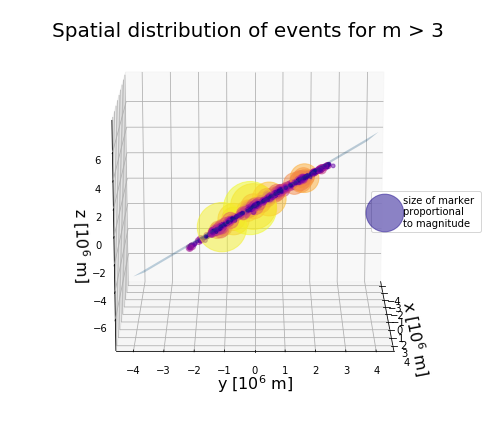

In [15]:
[v1, v2, v3] = Vt
normal = v3
xx, yy = np.meshgrid(range(-4,5), range(-4,5))# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy ) * 1. /normal[2]

m_bar = 3
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
x_coord = (x_coord - x_coord.mean())/x_coord.std()
y_coord = (y_coord - y_coord.mean())/y_coord.std()
z_coord = (z_coord - z_coord.mean())/z_coord.std()
magnitude = dfm['magnitude']

#%matplotlib nbagg

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, z, alpha=0.3)
ax.scatter(x_coord, y_coord, z_coord, 
           s=np.exp(magnitude*1.5)/np.exp(3), c = magnitude, marker="o", alpha = 0.5, 
           label = 'size of marker \nproportional \nto magnitude', cmap = 'plasma')
ax.set_xlabel("x [$10^6$ m]", fontsize = 16)
ax.set_ylabel("y [$10^6$ m]", fontsize = 16)
ax.set_zlabel("z [$10^6$ m]", fontsize = 16)
ax.set_title('Spatial distribution of events for m > 3', fontsize = 20)
ax.legend(loc = 'center right')
#print('azim = ', azim)
ax.view_init(elev = 15, azim = 0)
plt.tight_layout()
plt.show()

In [16]:
plt.close()
%matplotlib inline

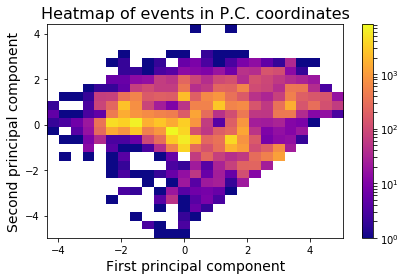

In [17]:
from matplotlib.colors import LogNorm
plt.figure(211)

# farlo in 3D con le barre?
plt.hist2d(Xp[0], Xp[1], bins = 25, norm = LogNorm(), cmap = "plasma")
plt.colorbar()
plt.xlabel('First principal component', fontsize = 14)
plt.ylabel('Second principal component', fontsize = 14)
plt.title('Heatmap of events in P.C. coordinates', fontsize = 16)
plt.tight_layout()
plt.show()
plt.close()

## 1.4 - Tree architecture

Here we want to exploit the information contained in the 'prev_event' column in order to be able to compute quantities such as distance and waiting time between an event and his ancestor.

First of all we iteratively created a nested dictionary, containing as keys the IDs of the primes events (i.e. the ones labelled with 'prev_event' = 1) and as values a dictionary with:
* the "depth" of the event in the cause-effect chain (i.e. 0 for the prime events, 1 for the ones caused by them, 2 for the ones caused by events of depth 1 and so on so forth);
* the "children" of that event, i.e. the events that have as prev_event the id of the event considered; "children" value contains itself a dictionary like the one just described for the prime events, hence the nested structure.

In [18]:
def evees_light(df, index=-1, depth=0):
    dataset = {}
    df_filtered = df[df["prev_event"]==index]
    lenght =  df_filtered.shape[0]
    for i in range(lenght):
        event = df_filtered.iloc[i]
        dataset[str(int(event["event"]))] = {"depth" : depth}
        dataset[str(int(event["event"]))]["children"] = evees_light(df, index=int(event["event"]), depth = depth + 1)
    return dataset

Then we mapped the dictionary so obtained in a list of dictionaries, whose indexes are the depth of the events (ranging from 0 to max_depth, that is unknown a priori); the entry of the list of index i is a dictionary that has as keys the IDs of the events of depth = i and as values the IDs of its children.

In [19]:
def write_dict_array(dataset, dict_array):
    for k in dataset.keys():
        depth = dataset[k]['depth']
        # k is the keyword, children_ids are the values
        if len(dict_array) < depth + 1 :
            while len(dict_array) < depth + 1:
                dict_array.append({})
        else:
            dict_array[depth][k] = list(dataset[k]['children'].keys())
        if len(list(dataset[k]['children'].keys())) != 0:
            write_dict_array(dataset[k]['children'], dict_array)

In [20]:
tree_dataset = evees_light(df)
v_dict = [{}]
write_dict_array(tree_dataset, v_dict)

Now we use the list of dictionaries to add the depth and the number of children (or number of edges if we think of the dataset as an oriented graph) of each event by adding two columns to the original dataset.

In [21]:
N = df.shape[0]
edges = np.zeros(N)
depths = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        #print(k)
        edges[int(k)] = len(v_dict[d][k])
        depths[int(k)] = d
        
df['edges'] = edges
df['depth'] = depths

In [22]:
# From the new features we can see an interesting thing: the event with the highest magnitude (7.3) is not prime 
# (because it hasn't prev_event = -1), but it happend after a concatenation of 11 earthquakes and subsequently caused 
# other 4209 events!
df[df['magnitude'] == 7.3]

,event,prev_event,time,magnitude,x,y,z,edges,depth
39805,39805,39804,3.309144e+08,7.3,-2341818,-4710335,3575181,4209.0,11.0


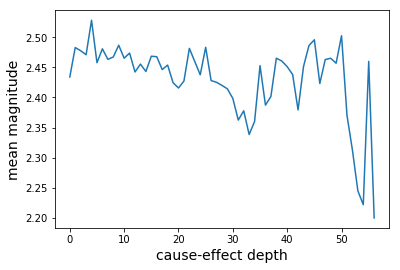

In [23]:
# Furthermore we can see that depth isn't a good indicator of magnitude and that in fact one can't find any relation
# between the two
mean_mag = df.groupby('depth')['magnitude'].mean()
depth_axis = [i for i in range(len(mean_mag))]
plt.plot(depth_axis, mean_mag)
plt.xlabel('cause-effect depth', fontsize = 14)
plt.ylabel('mean magnitude', fontsize = 14)
plt.show()

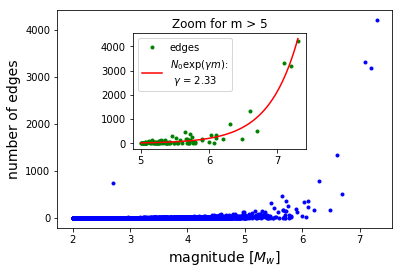

In [24]:
# as we could expect the events with higher magnitudes have much more edges than the ones with lower magnitudes. 
# In fact the dependence is exponential with m

def my_expon1(x, No, gamma):
    return No*np.exp(gamma*x)

plt.plot(df['magnitude'], df['edges'] , '.b')
plt.xlabel('magnitude [$M_w$]', fontsize = 14)
plt.ylabel('number of edges', fontsize = 14)

df5 = df[df['magnitude'] > 5]
ax = plt.axes([0.3, 0.4, 0.4, 0.4])
ax.set_title('Zoom for m > 5')
ax.plot(df5['magnitude'], df5['edges'] , '.g')
params1, _ = optimize.curve_fit(my_expon1, df5['magnitude'], df5['edges'])
[No, gamma] = params1
x_axis = np.linspace(5,7.3,100)
ax.plot(x_axis, my_expon1(x_axis, *params1), 'r-', 
        label = '$N_0$exp($\gamma m$):\n $\gamma$ = {}'.format(round(gamma,2)))
ax.legend()
    
plt.show()

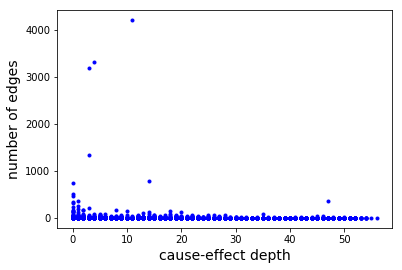

In [25]:
# again depth isn't a good indicator of edges (as it wasn't for magnitude)
plt.plot(df['depth'], df['edges'], 'b.')
plt.xlabel('cause-effect depth', fontsize = 14)
plt.ylabel('number of edges', fontsize = 14)
plt.show()

# 2 - Distribution of waiting time 
Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.

In [26]:
def select_bin_number_mod(x, m = 2, min_nbin = 7, fraction = 0.001):
    """Starts from evenly separed bins and merges the last ones until the tail's counts are 
        major or equal to the 'fraction' of the total number of occurrencies, given the 
        constraint that the final number of bins has to be min_nbin."""
    
    # added a factor exp(m-2) to take into account the exponential decrease of total N
    n_min = max([int(fraction*len(x)*np.exp(m-2)),10])
    print('For m = {} and N = {} the minimum number of events in the tail required is : {}'.format(m, len(x), n_min))
    print('Minimum accuracy expected : {}'.format(round(1 - 1/np.sqrt(n_min),2)))
    #n_min = fraction*len(x)
    
    n, bin_extremes, _ = plt.hist(x, bins = min_nbin )
    plt.close()
    last_n = n[-1]
    
    if last_n > n_min:
        return min_nbin, bin_extremes
    else:
        i = min_nbin 
        nbin = min_nbin
        while last_n < n_min and nbin < 100:
            nbin = nbin + 1
            n, _, _ = plt.hist(x, bins = nbin )
            plt.close()
            last_n = n[i-1:].sum()
        
        if last_n > n[min_nbin-2]:
            print('-> reducing the final number of bins to {}: \n'.format(min_nbin - 1))
            nbin, bins = select_bin_number_mod(x, m = m, min_nbin = min_nbin - 1)
        else:   
            n, bin_extremes, _ = plt.hist(x, bins = nbin )
            plt.close()
            bins = np.concatenate((bin_extremes[:min_nbin],bin_extremes[-1:]))
        
        return nbin, bins

In [27]:
#look if they are all used or if there is some useless
def logP(t, A, B):
    return A + B*t

def logPmod(t, A, B, C):
    return A + B/t**C

def logt(t, p, q, r):
    return p*np.log(t*r) + q

def loglogt(t, p, q):
    return p*t + q

def poissonian(x, A = 1, l = 1, x0 = 1):
    from scipy.special import factorial 
    return (x*x0)**l/factorial(x*x0)*np.exp(-l)*A

def poissonian2(x, A = 1, l = 1, x0 = 1):
    from scipy.special import factorial 
    return (x*x0)**l/factorial(l)*np.exp(-x*x0)*A


def poissonian4(x, A = 1, mu = 1):
    from scipy.stats import poisson
    return A*poisson.pmf(x, mu)

In [28]:
help(np.float_power)

Help on ufunc object:

float_power = class ufunc(builtins.object)
 |  Functions that operate element by element on whole arrays.
 |  
 |  To see the documentation for a specific ufunc, use `info`.  For
 |  example, ``np.info(np.sin)``.  Because ufuncs are written in C
 |  (for speed) and linked into Python with NumPy's ufunc facility,
 |  Python's help() function finds this page whenever help() is called
 |  on a ufunc.
 |  
 |  A detailed explanation of ufuncs can be found in the docs for :ref:`ufuncs`.
 |  
 |  Calling ufuncs:
 |  ===============
 |  
 |  op(*x[, out], where=True, **kwargs)
 |  Apply `op` to the arguments `*x` elementwise, broadcasting the arguments.
 |  
 |  The broadcasting rules are:
 |  
 |  * Dimensions of length 1 may be prepended to either array.
 |  * Arrays may be repeated along dimensions of length 1.
 |  
 |  Parameters
 |  ----------
 |  *x : array_like
 |      Input arrays.
 |  out : ndarray, None, or tuple of ndarray and None, optional
 |      Alternate

In [29]:
def plot_Pm_t2(m, df):
    print('\nTime distribution for m = ', m, '\n')
    # waiting time for events of magnitude > m
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    # eliminating a couple of anomalous events
    prova = time_d[time_d != time_d.max()]
    maximum = prova.max()
    if time_d.max()*3/4 > maximum:
        time_d = prova
    
    # time differences rescaled to [0,1]
    time_diff = time_d/time_d.max()
    
    # computing suitable sizes of bins
    original_bin_number, bins = select_bin_number_mod(time_diff, m = m)
    bin_number = len(bins) - 1
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
    
    n_tailed, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    
    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.')
    #, label = 'entries with \npoisson error'    #ax1.legend(loc = 'upper right')
    ax1.set_yscale('log')
    ax1.set_xlabel('normalized waiting times', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(time_diff)))
    
    # adding an inner plot of the relative accuracy (i.e. 1 - rel.err.) for the entries of the histogram
    ax3 = plt.axes([0.32, 0.55, 0.15, 0.25])
    accuracies = 1 - 1./np.sqrt(n)
    plt.plot(bin_centers, accuracies, 'g.')
    plt.title('Accuracy')
    plt.xlabel('bin labels')
    plt.setp(ax3, xticks = bin_centers, xticklabels =  [i+1 for i in range(len(bin_centers))])
    
    #print('Occurrencies for the first bin with {} original bins: '.format(bin_number), int(n[0]), '\n')
    print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')
    
    # linear fit over the log of the entries
    params1, cov1 = optimize.curve_fit(loglogt, np.log(bin_centers), np.log(n), p0 = [-1,5])
    [p,q] = params1
    var_p = np.diag(cov1)[0]

    y_errors = 1./np.sqrt(n)
    ax2.errorbar(np.log(bin_centers), np.log(n), yerr = y_errors ,fmt ='r.', label = 'entries with errors')
    ax2.plot(np.log(bin_centers), loglogt(np.log(bin_centers), *params1), 
             label = 'f(x) = px + q\np = {} \nq = {}'.format(round(params1[0],1),round(params1[1],1)))
             #label = 'p = {} \nq = {}\n$\chi^2$ = {} \np-value = {}'\
             #.format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(pv,2)))
    ax2.legend()
    ax2.set_xlabel('normalized waiting times [logscale]', fontsize = 14)
    ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)
    
    # Finally we can plot in the first panel the obtained fit:
    x_axis = np.linspace(bin_centers[0], bin_extremes[-1], 100)
    #print(ax1)
    ax1.plot(x_axis, np.exp(p*np.log(x_axis)+q))

    plt.show()
    plt.close()
    
    return p, q, np.sqrt(var_p)


Time distribution for m =  2.0 

For m = 2.0 and N = 106196 the minimum number of events in the tail required is : 106
Minimum accuracy expected : 0.9
Number of bins merged into the tail: 5 



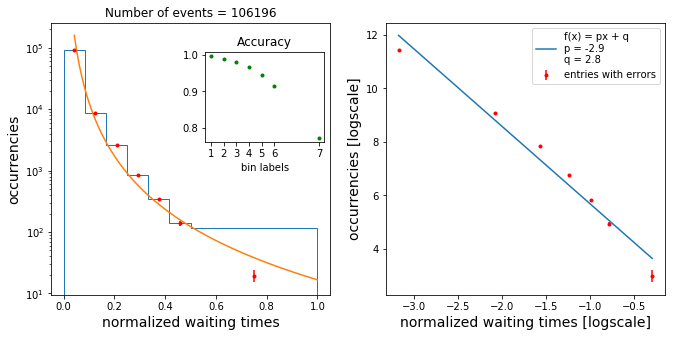


Time distribution for m =  2.5 

For m = 2.5 and N = 37620 the minimum number of events in the tail required is : 62
Minimum accuracy expected : 0.87
Number of bins merged into the tail: 7 



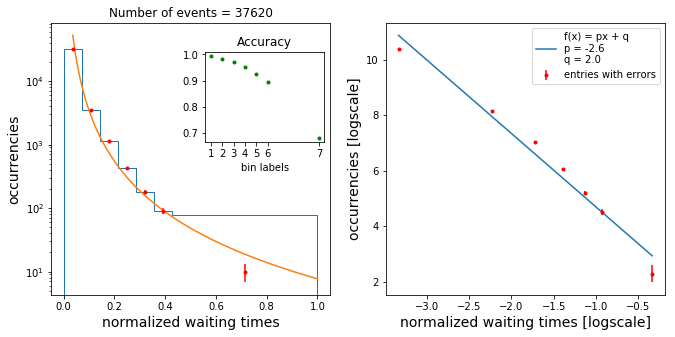


Time distribution for m =  3.0 

For m = 3.0 and N = 11457 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82
Number of bins merged into the tail: 5 



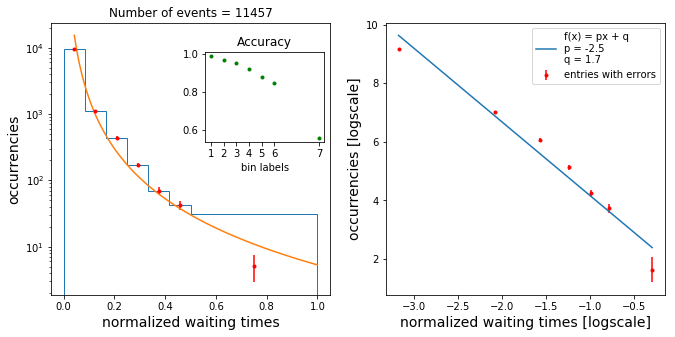


Time distribution for m =  3.5 

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
Number of bins merged into the tail: 4 



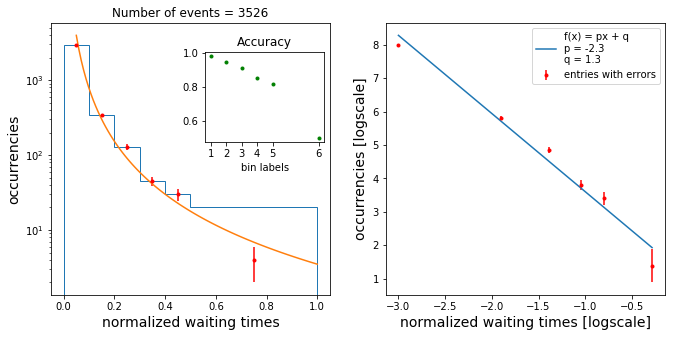


Time distribution for m =  4.0 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 2 



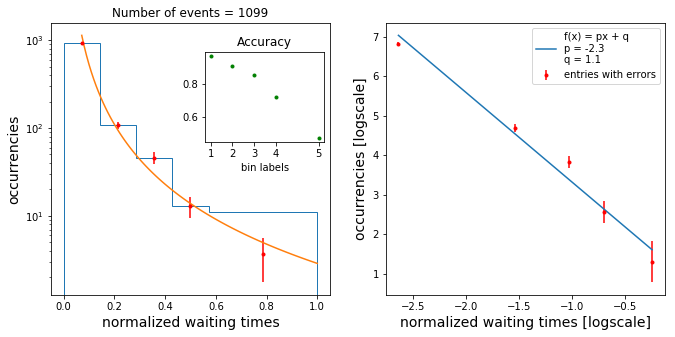


Time distribution for m =  4.5 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 3 



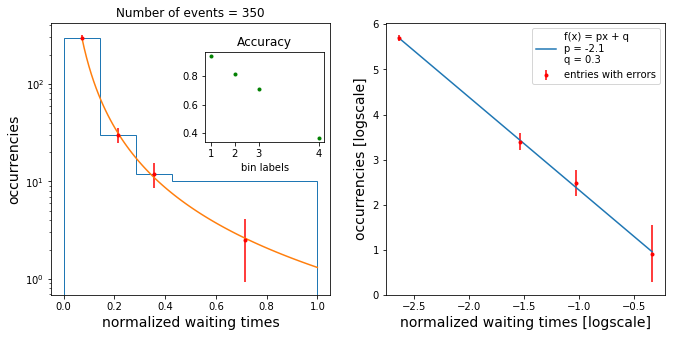

In [30]:
# we choose to study the data for m between 2 and 4.5, because above 5 we get just 104 samples 
# and there isn't enough information to fit anything but the initial peak of the distribution.

ms = np.linspace(2,4.5,6)
ps1 = np.zeros(len(ms))
qs1 = np.zeros(len(ms))
p_errors = np.zeros(len(ms))
# we could also use the covariance of the parameters from curve_fit in order to have an error on p !

for i in range(len(ms)):
    m = ms[i]
    ps1[i], qs1[i], p_errors[i] = plot_Pm_t2(m, df)

### 2.1 - Scaling of the exponent as a function of m

Distribution considered:

$P_{m>\bar{m}}(t_w) = At_w^{-\alpha(\bar{m})}$,

where $\alpha = -p$ and A is just a normalization constant.

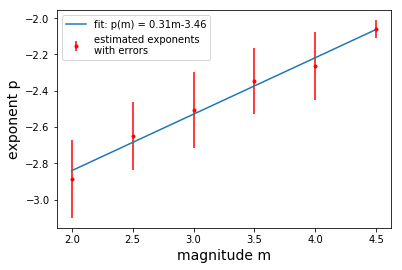

In [31]:
# we can see how the exponent is a linear funcion of m

slope, intercept, r_value, p_value, std_err = stats.linregress(ms, ps1)
plt.errorbar(ms, ps1, yerr = p_errors, fmt = '.r', label = 'estimated exponents \nwith errors' )
plt.plot(ms, intercept+slope*ms, label = 'fit: p(m) = %.2fm%.2f'%(slope,intercept))
#plt.title('Dipendence on magnitude of the exponent p')
plt.ylabel('exponent p', fontsize = 14)
plt.xlabel('magnitude m', fontsize = 14)
plt.legend()
plt.show()

### 2.2 - Waiting time distribution between concatenated events

We now analyze the distribution of waiting times but considering only the waiting times between an event and the ancestor.


In general we expect a greater exponent $\alpha$ of $P_{m>\bar{m}}(t_w) = At_w^{-\alpha(\bar{m})}$ because we consider much more correlated pairs of event than in the previous case.

In [32]:
time_diff_tree = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        # previous vertex has id = k, children vertexes have ids [ v_dict[d][k] ]
        for j in v_dict[d][k]:
            #print('Computing {}-> {} waiting time.'.format(k,j))
            time_diff_tree[int(j)] = df['time'].iloc[int(j)] - df['time'].iloc[int(k)]
            
time_diff_tree = time_diff_tree[time_diff_tree > 0]

In [33]:
def plot_Pm_t_tree(time_d, m = 2):
    # time differences rescaled to [0,1]
    time_diff = time_d/time_d.max() 
    
    # computing suitable sizes of bins
    original_bin_number, bins = select_bin_number_mod(time_diff, m = m)
    bin_number = len(bins) - 1
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
    
    n_tailed, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')
    
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.')
    #, label = 'entries with \npoisson error'    #ax1.legend(loc = 'upper right')
    ax1.set_yscale('log')
    ax1.set_xlabel('normalized waiting times', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(time_diff)))
    
    # adding an inner plot of the relative accuracy (i.e. 1 - rel.err.) for the entries of the histogram
    ax3 = plt.axes([0.32, 0.55, 0.15, 0.25])
    accuracies = 1 - 1./np.sqrt(n)
    plt.plot(bin_centers, accuracies, 'g.')
    plt.title('Accuracy')
    plt.xlabel('bin labels')
    #plt.ylabel('accuracy')
    #plt.ylim(bottom = 0, top = 1)
    plt.setp(ax3, xticks = bin_centers, xticklabels =  [i+1 for i in range(len(bin_centers))])
    
    #print('Occurrencies for the first bin with {} original bins: '.format(bin_number), int(n[0]), '\n')
    print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    #n = np.concatenate((n[:-1], n[-1:]/(original_bin_number+1-bin_number)))
    # linear fit over the log of the entries
    params1, _ = optimize.curve_fit(loglogt, np.log(bin_centers), np.log(n), p0 = [-1,5])
    [p,q] = params1
    #print('p = {}\nq = {}'.format(round(p,2), round(q,2)))
    
    # chi squared and p-value tests
    #chisq, pv = chisquare(np.log(n), loglogt(np.log(bin_centers), *params1), ddof = 2 )
    
    y_errors = 1./np.sqrt(n)
    ax2.errorbar(np.log(bin_centers), np.log(n), yerr = y_errors ,fmt ='r.', label = 'entries with errors')
    ax2.plot(np.log(bin_centers), loglogt(np.log(bin_centers), *params1), 
             label = 'f(x) = px + q\np = {} \nq = {}'.format(round(params1[0],1),round(params1[1],1)))
             #label = 'p = {} \nq = {}\n$\chi^2$ = {} \np-value = {}'\
             #.format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(pv,2)))
    ax2.legend()
    ax2.set_xlabel('normalized waiting times [logscale]', fontsize = 14)
    ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)
    
    # Finally we can plot in the first panel the obtained fit:
    x_axis = np.linspace(bin_centers[0], bin_extremes[-1], 100)
    #print(ax1)
    ax1.plot(x_axis, np.exp(p*np.log(x_axis)+q))
    
    plt.show()
    plt.close()
    
    return p, q

For m = 2 and N = 71481 the minimum number of events in the tail required is : 71
Minimum accuracy expected : 0.88
-> reducing the final number of bins to 6: 

For m = 2 and N = 71481 the minimum number of events in the tail required is : 71
Minimum accuracy expected : 0.88
-> reducing the final number of bins to 5: 

For m = 2 and N = 71481 the minimum number of events in the tail required is : 71
Minimum accuracy expected : 0.88
Number of bins merged into the tail: 4 



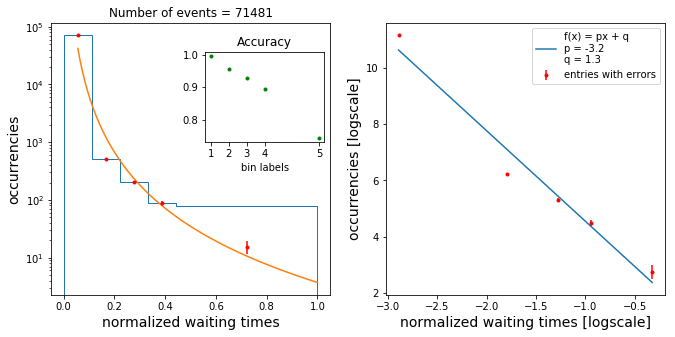

In [34]:
p_tree, q_tree = plot_Pm_t_tree(time_diff_tree )

# 3 - Distance distribution between events

Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. Also here make a clever choice for the bin sizes and try several values of $m$.

In [35]:
def plot_Pm_r2(m, df):
    print('\nDistance distribution for m = ', m, '\n')
    dfm = df[df['magnitude'] > m]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_norm = r/r.max()
    
    # computing suitable sizes of bins
    original_bin_number, bins = select_bin_number_mod(r_norm, m=m, min_nbin = 10)
    bin_number = len(bins) - 1
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(6, 5))
    
    n_tailed, bin_extremes, _  = ax1.hist(r_norm, bins = bins, histtype = 'step')
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    
    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.')
    ax1.set_xlabel('normalized distances', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(r_norm)))
    ax1.set_yscale('log')
    print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

    plt.show()
    plt.close()
    return r.mean(), r.std()/np.sqrt(len(r))


Distance distribution for m =  2.0 

For m = 2.0 and N = 106197 the minimum number of events in the tail required is : 106
Minimum accuracy expected : 0.9
Number of bins merged into the tail: 1 



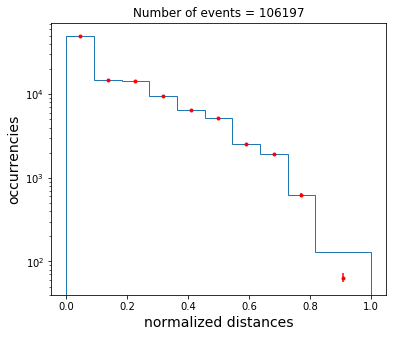


Distance distribution for m =  2.5 

For m = 2.5 and N = 37621 the minimum number of events in the tail required is : 62
Minimum accuracy expected : 0.87
Number of bins merged into the tail: 1 



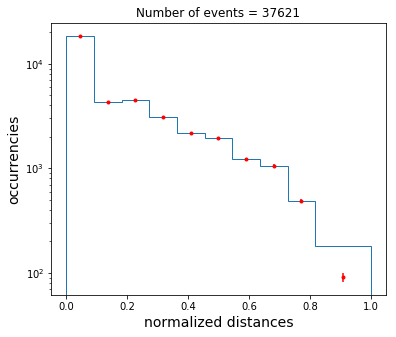


Distance distribution for m =  3.0 

For m = 3.0 and N = 11457 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82
Number of bins merged into the tail: 2 



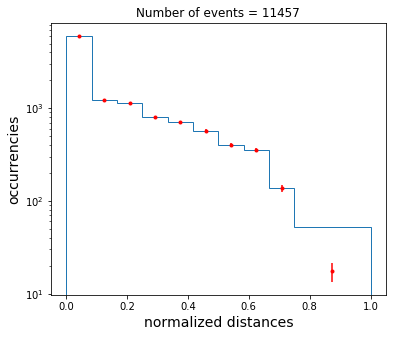


Distance distribution for m =  3.5 

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
Number of bins merged into the tail: 2 



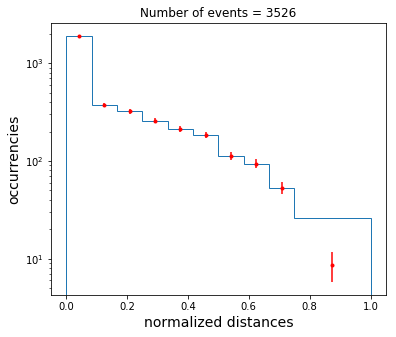


Distance distribution for m =  4.0 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 3 



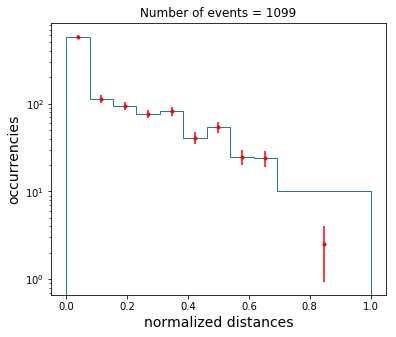


Distance distribution for m =  4.5 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 9: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 8: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 7: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 



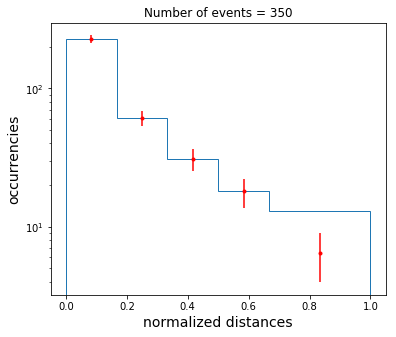

In [36]:
ms = np.linspace(2,4.5,6)

r_mean = np.zeros(len(ms))
r_std = np.zeros(len(ms))

for i in range(len(ms)):
    m = ms[i]
    r_mean[i], r_std[i] = plot_Pm_r2(m, df)
    #plot_Pm_r2(m, df)

## Distance distribution decomposition

Given the difficulty in understanding the spatial distribution of the events, we started to analyze all the factor that can influence the distance between two events.

First of all we compared the mean distance considering two ensambles:
* the one in which we consider all events and we compute for each one the distance with the event with the next ID number
* the one in which we consider only prime events (that in some sense can be thought as independent and thus randomly distributed)

Then we also plotted the mean distance between two consequent events, that hasn't been studied as a function of m because this would probably break the "cause-effect chain" by removing previous events of magnitude < m. 

## 3.1 - Distance distribution between consequent events

In [37]:
distance_tree = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        # previous vertex has id = k, children vertexes have ids [ v_dict[d][k] ]
        for j in v_dict[d][k]:
            #print('Computing {}-> {} waiting time.'.format(k,j))
            distance_tree[int(j)] = np.linalg.norm(df[['x','y','z']].iloc[int(j)] - df[['x','y','z']].iloc[int(k)])
            
distance_tree = distance_tree[distance_tree > 0]

In [38]:
# we want now to analyse the core of the distribution, neglecting the tail for the moment
print('Max dstance: ', distance_tree.max())
dist_truncated = distance_tree[distance_tree < 100000]

samples_discarded = len(distance_tree)-len(dist_truncated)
print(len(distance_tree))
print(len(dist_truncated))
print(samples_discarded)
percentage_discarded = samples_discarded / len(distance_tree)
print('Number of samples discarded : {} ({}%)'.format(samples_discarded, round(percentage_discarded*100,1)))

Max dstance:  622385.861082978
71481
70644
837
Number of samples discarded : 837 (1.2%)


In [73]:
def plot_Pm_r_tree(time_diff, bin_number = 10):
    
    n, bin_extremes, _  = plt.hist(time_diff, bins = bin_number, histtype = 'step', cumulative = True, density = True)
    plt.xlabel('normalized waiting times', fontsize = 14)
    plt.ylabel('occurrencies', fontsize = 14)
    #plt.axhline(0.01, color = 'red', label = '1% line')
    plt.axhline(0.90, color = 'orange', label = '90% line')
    #plt.xscale('log')
    #plt.yscale('log')
    plt.title('Number of events = {}'.format(len(time_diff)))
    plt.legend(loc = 10)
    plt.show()
    plt.close()
    

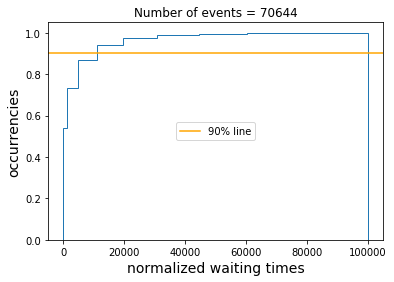

In [74]:
bins = np.power(np.linspace(0, np.sqrt(dist_truncated.max()),10),2)
plot_Pm_r_tree(dist_truncated, bin_number = bins)
#plot_Pm_r_tree(distance_tree, 100)

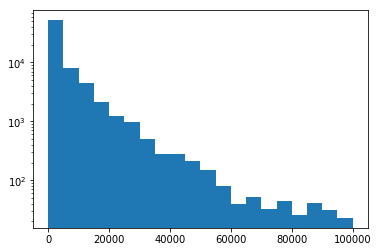

In [87]:
#dist_trunc = dist_truncated[dist_truncated < 50000]
dist_trunc = dist_truncated
n, bins, _ = plt.hist(dist_trunc, bins = 20)
plt.yscale('log')
plt.show()

20
20


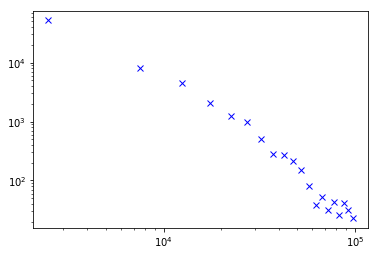

In [88]:
bin_centers = (bins[:-1] + bins[1:])/2
print(len(bin_centers))
print(len(n))
plt.plot(bin_centers, n, 'bx')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [103]:
def log_cauchy_distribution(x, a, D_x):
    return a - np.log(1 + np.power(x/D_x,2))

def cauchy_distribution(x, A, D_x):
    return (A/D_x)/(1 + np.power(x/D_x,2))

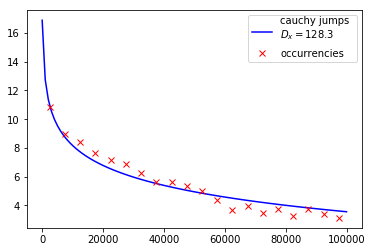

In [94]:
params1, cov1 = optimize.curve_fit(log_cauchy_distribution, bin_centers, np.log(n), p0 = [np.log(n[0]), 100])
[a,D_x] = params1
x_axis = np.linspace(bins[0], bins[-1],100)
plt.plot(x_axis, log_cauchy_distribution(x_axis,*params1), 'b-', label = 'cauchy jumps \n$D_x = %.1f $'%(D_x))
plt.plot(bin_centers, np.log(n), 'rx', label = 'occurrencies')
plt.legend()
plt.show()

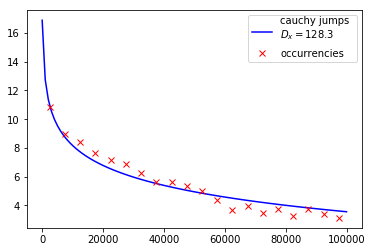

In [107]:
bin_number = 20
n, bins, _ = plt.hist(dist_truncated, bins = bin_number)
plt.close()
bin_centers = (bins[:-1] + bins[1:])/2
params1, cov1 = optimize.curve_fit(log_cauchy_distribution, bin_centers, np.log(n), p0 = [np.log(n[0]), 100])
[a,D_x] = params1
x_axis = np.linspace(bins[0], bins[-1],100)
plt.plot(x_axis, log_cauchy_distribution(x_axis,*params1), 'b-', label = 'cauchy jumps \n$D_x = %.1f $'%(D_x))
plt.plot(bin_centers, np.log(n), 'rx', label = 'occurrencies')
plt.legend()
plt.show()
plt.close()


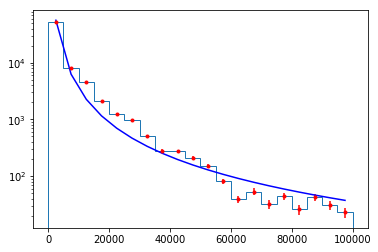

In [109]:
plt.hist(dist_truncated, bins = bin_number, histtype = 'step')
plt.plot(bin_centers, np.exp(log_cauchy_distribution(bin_centers,*params1)), 'b-')
plt.errorbar(bin_centers, n, yerr = np.sqrt(n), fmt = 'r.')
plt.yscale('log')
plt.show()

In [ ]:
def plot_Pm_r_tree(time_diff, bin_number = 10):
    
    n, bin_extremes, _  = plt.hist(time_diff, bins = bin_number, histtype = 'step', cumulative = True, density = True)
    plt.xlabel('normalized waiting times', fontsize = 14)
    plt.ylabel('occurrencies', fontsize = 14)
    #plt.axhline(0.01, color = 'red', label = '1% line')
    plt.axhline(0.90, color = 'orange', label = '90% line')
    #plt.xscale('log')
    #plt.yscale('log')
    plt.title('Number of events = {}'.format(len(time_diff)))
    plt.legend(loc = 10)
    plt.show()
    plt.close()
    

## Distance distribution decomposition

Given the difficulty in understanding the spatial distribution of the events, we started to analyze all the factor that can influence the distance between two events.

First of all we compared the mean distance considering two ensambles:
* the one in which we consider all events and we compute for each one the distance with the event with the next ID number
* the one in which we consider only prime events (that in some sense can be thought as independent and thus randomly distributed)

Then we also plotted the mean distance between two consequent events, that hasn't been studied as a function of m because this would probably break the "cause-effect chain" by removing previous events of magnitude < m. 

Mean distance between consequent events: 7467 m


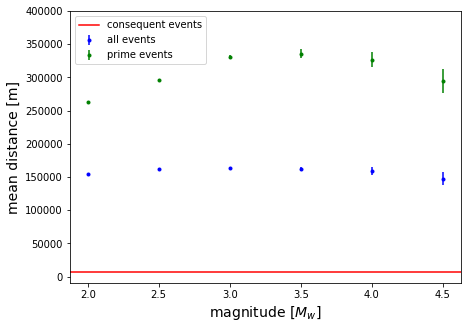

In [42]:
# Mean distance between only prime events is larger than the one obtained considering all events
print('Mean distance between consequent events: %.0f m'%distance_tree.mean())

r_indep_events = []
r_indep_std = []
for i in range(len(ms)):
    dfm = df[(df['magnitude'] > ms[i]) & (df['prev_event'] == -1)]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_indep_events.append(r.mean())
    r_indep_std.append(r.std()/np.sqrt(len(r)))

plt.figure(figsize = (7,5))
plt.errorbar(ms, r_mean, yerr = r_std, fmt = 'b.', label = 'all events')
plt.errorbar(ms, r_indep_events, yerr = r_indep_std, fmt = 'g.', label = 'prime events')
plt.axhline(distance_tree.mean(), label = 'consequent events', color = 'red')
#plt.legend(loc = 'lower right')
plt.legend()
plt.ylim(top = 400000)
plt.xlabel('magnitude [$M_w$]', fontsize = 14)
plt.ylabel('mean distance [m]', fontsize = 14)
plt.show()

In [43]:
def poissonian3(x, A=1, l = 1):
    from scipy.special import gamma
    return A*np.float_power(l,x)/gamma(x)*np.exp(-l)

def minus_poissonian3(x, A=1, l = 1):
    from scipy.special import gamma
    return -A*np.float_power(l,x)/gamma(x)*np.exp(-l)

In [44]:
def plot_Pm_r_poisson(m, df):
    print('\nDistance distribution for m = ', m, '\n')
    dfm = df[df['magnitude'] > m]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_norm = r/r.max()
    #r.astype(int)
    
    # computing suitable sizes of bins
    original_bin_number, bins = select_bin_number_mod(r_norm, m=m, min_nbin = 10)
    
    bin_number = len(bins) - 1
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(6, 5))
    
    n_tailed, bin_extremes, _  = ax1.hist(r_norm, bins = bins, histtype = 'step')
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    delta_bin = bin_centers[1]-bin_centers[0]
    print('Bin width: ', delta_bin, '\n')
    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    
    area = n[:-1].sum()*delta_bin + n[-1]*delta_bin * (original_bin_number-bin_number)
    print('Area = ', area, '\n')
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.', label = 'entries with \npoissonian errors')
    ax1.set_xlabel('normalized distances', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(r)))
    
    print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

    #params1, cov1 = optimize.curve_fit(poissonian, bin_centers, n, p0 = [n[0],0.3, 10])
    print('bin_centers: ', bin_centers, '\n')
    params1, cov1 = optimize.curve_fit(poissonian3, bin_centers, n, p0 = [n[0], 0.3])
    [A,l] = params1
    
    solution = optimize.minimize_scalar(minus_poissonian3, args=(params1[0],params1[1],))
    print('Solution: ', solution.x, '\n')
    ax1.axvline(solution.x)
    ax1.axvline(r.mean()/r.max())
    x_axis = np.linspace(bin_extremes[0], bin_extremes[-1],100)
    ax1.plot(x_axis, poissonian3(x_axis,*params1), label = 'poissonian \n$x_{max} = %.3f $'%(solution.x))
    #ax1.plot(x_axis, n.sum()*poissonian3(x_axis,*params1), label = 'poissonian \n $\lambda$ = %.2f \n $x_0 = %.2f$'%(l,x0))
    ax1.legend()
    plt.show()
    plt.close()
    
    return A, l, solution.x, r.max(), r.mean(), r.std()/np.sqrt(len(r))


Distance distribution for m =  2.0 

For m = 2.0 and N = 37157 the minimum number of events in the tail required is : 37
Minimum accuracy expected : 0.84
Bin width:  0.09090821822719852 

Area =  3375.4675968849947 

Number of bins merged into the tail: 1 

bin_centers:  [0.04546371 0.13637193 0.22728015 0.31818836 0.40909658 0.5000048
 0.59091302 0.68182124 0.77272945 0.90909178] 

Solution:  0.1589761827919206 



/home/nicola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in float_power
  This is separate from the ipykernel package so we can avoid doing imports until


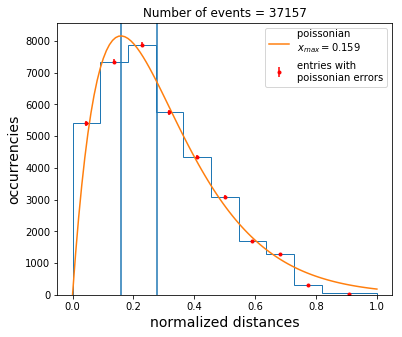


Distance distribution for m =  2.25 

For m = 2.25 and N = 22268 the minimum number of events in the tail required is : 28
Minimum accuracy expected : 0.81
Bin width:  0.09090821822719852 

Area =  2021.253324063532 

Number of bins merged into the tail: 1 

bin_centers:  [0.04546371 0.13637193 0.22728015 0.31818836 0.40909658 0.5000048
 0.59091302 0.68182124 0.77272945 0.90909178] 

Solution:  0.17253842446217119 



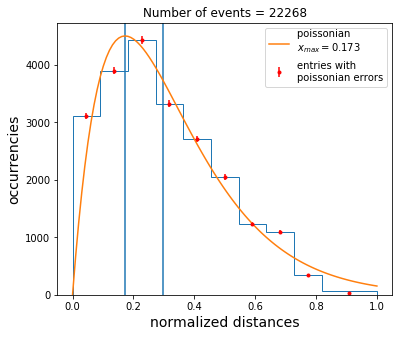


Distance distribution for m =  2.5 

For m = 2.5 and N = 12482 the minimum number of events in the tail required is : 20
Minimum accuracy expected : 0.78
Bin width:  0.09089992402615604 

Area =  1132.0222038597342 

Number of bins merged into the tail: 1 

bin_centers:  [0.0455508  0.13645072 0.22735065 0.31825057 0.40915049 0.50005042
 0.59095034 0.68185027 0.77275019 0.90910008] 

Solution:  0.17621698363566693 



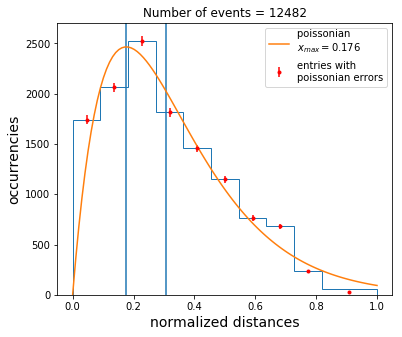


Distance distribution for m =  2.75 

For m = 2.75 and N = 6848 the minimum number of events in the tail required is : 14
Minimum accuracy expected : 0.73
Bin width:  0.09088156427712449 

Area =  621.3572549627002 

Number of bins merged into the tail: 1 

bin_centers:  [0.04574358 0.13662514 0.2275067  0.31838827 0.40926983 0.5001514
 0.59103296 0.68191453 0.77279609 0.90911844] 

Solution:  0.17937336146810243 



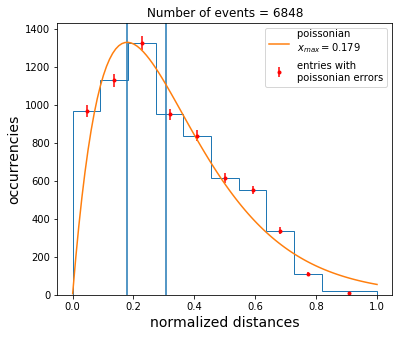


Distance distribution for m =  3.0 

For m = 3.0 and N = 3567 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Bin width:  0.09088156427712449 

Area =  323.17484256945465 

Number of bins merged into the tail: 1 

bin_centers:  [0.04574358 0.13662514 0.2275067  0.31838827 0.40926983 0.5001514
 0.59103296 0.68191453 0.77279609 0.90911844] 

Solution:  0.19685285133276614 



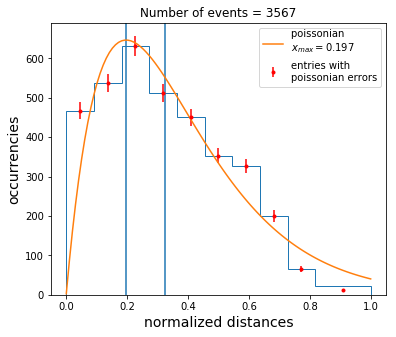


Distance distribution for m =  3.25 

For m = 3.25 and N = 1866 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Bin width:  0.09083961979128488 

Area =  168.87085319199858 

Number of bins merged into the tail: 1 

bin_centers:  [0.04618399 0.13702361 0.22786323 0.31870285 0.40954247 0.50038209
 0.59122171 0.68206133 0.77290095 0.90916038] 

Solution:  0.19190377295532945 



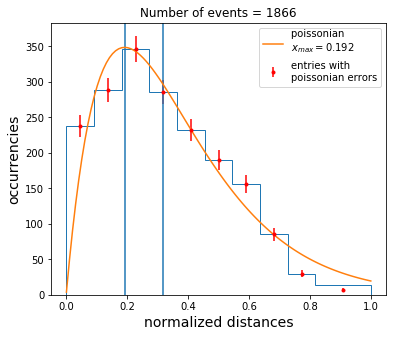


Distance distribution for m =  3.5 

For m = 3.5 and N = 993 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Bin width:  0.09050791887023053 

Area =  89.33131592491753 

Number of bins merged into the tail: 1 

bin_centers:  [0.04966685 0.14017477 0.23068269 0.32119061 0.41169853 0.50220645
 0.59271437 0.68322228 0.7737302  0.90949208] 

Solution:  0.18862208975993183 



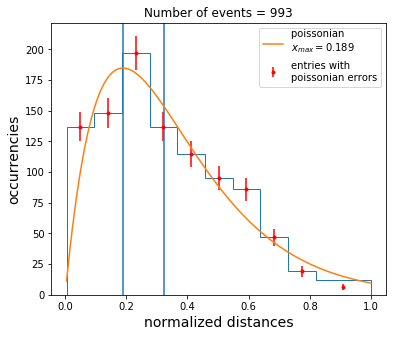


Distance distribution for m =  3.75 

For m = 3.75 and N = 555 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Bin width:  0.08290703150310166 

Area =  45.54359597237051 

Number of bins merged into the tail: 2 

bin_centers:  [0.04656914 0.12947617 0.2123832  0.29529023 0.37819726 0.4611043
 0.54401133 0.62691836 0.70982539 0.87563945] 

Solution:  0.20948968347479005 



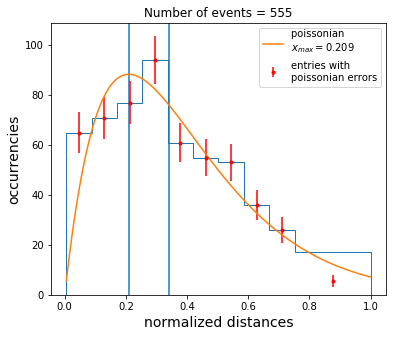


Distance distribution for m =  4.0 

For m = 4.0 and N = 300 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Bin width:  0.0758895134768498 

Area =  22.53918550262439 

Number of bins merged into the tail: 3 

bin_centers:  [0.05138108 0.1272706  0.20316011 0.27904962 0.35493914 0.43082865
 0.50671816 0.58260768 0.65849719 0.84822097] 

Solution:  0.20237404351141774 



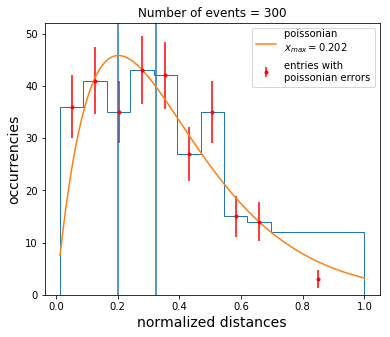

In [45]:
prime_df = df[df['prev_event'] == -1]
# reduced the range of m to [2,4] due to insufficient samples for higher magnitudes
pr_ms = np.linspace(2,4,9)

pr_As_r = np.zeros(len(pr_ms))
pr_ls_r = np.zeros(len(pr_ms))
pr_x_peak = np.zeros(len(pr_ms))
pr_r_max = np.zeros(len(pr_ms))
pr_r_mean = np.zeros(len(pr_ms))
pr_r_std = np.zeros(len(pr_ms))

for i in range(len(pr_ms)):
    m = pr_ms[i]
    pr_As_r[i], pr_ls_r[i], pr_x_peak[i], pr_r_max[i], pr_r_mean[i], pr_r_std[i] = plot_Pm_r_poisson(m, prime_df)
    #plot_Pm_r_poisson(m, prime_df)

The first important thing in discovering that prime events are distributed accordingly to a Poisson distribution is that poissonians have a centroid and we can use it as an significant estimator of the mean distance between prime events (before was just a rough estimator in absence of something better).

Below here we can see how the centroids of the poissonians, independently of the fact that are rescaled or not, can be considered constant in the margin of error. Hence we can say that at the core of the $P_m(r)$ distribution lies a poissonian process independent from the magnitude.

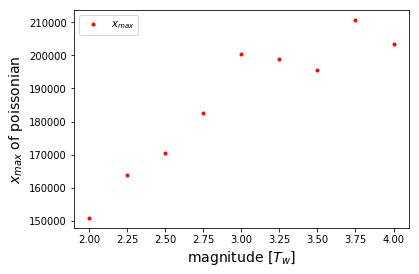

In [46]:
rescaled_peaks = np.multiply(pr_x_peak, pr_r_max)
#rescaled_errors = np.multiply(pr_ls_err,pr_r_max)
plt.plot(pr_ms, rescaled_peaks, 'r.', label = '$x_{max}$')
#plt.axhline(rescaled_lambdas.mean(), label = '$<\lambda>$: %.0f'%rescaled_lambdas.mean())
plt.xlabel('magnitude [$T_w$]', fontsize = 14)
plt.ylabel('$x_{max}$ of poissonian', fontsize = 14)
plt.legend()
plt.show()

## 4 - Range-conditioned waiting time distribution

Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. (In this statistics, if the following event is farther than $R$, skip the $t$ and go to the next pair)

In [47]:
# Function to plot waiting times with R condition (fixed m_min)

def Pm_t_Rcondition(m, R_fractions, df):
    #print('m = ', m, '\n')
    
    # distance and waiting times between events of magnitude > m
    dfm = df[df['magnitude'] > m]
    dfm = dfm.set_index(np.arange(len(dfm)))
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    #vector for fit parameters for each R_max fraction
    ps = []
    qs = []
    p_errors = []
    Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2)
    print('R_max fractions considered: ', Rs, '\n')
    #Repeat plots and fits for each R_max fraction
    # fra code
    #for i in range(1, R_fractions+1):
    for i in range(R_fractions):
        # building the mask to filter "distances < R" and apply that to original waiting times
        print("R_max = "+str(i+1)+"/"+str(R_fractions)+" * max_distance")
        # linearly spaced fractions - fra code
        #R_mask = pd.Series(np.concatenate((np.array([True]), r <= i/R_fractions*r.max())))
        R_mask = pd.Series(np.concatenate((np.array([True]), r <= Rs[i]*r.max())))
        dfmr = dfm[R_mask]
        r_norm = r[R_mask[1:]]/r.max()  
        time_diff = time_d[R_mask[1:]]/time_d.max()
        print("{} events hav been removed ({}%)\n"\
              .format(len(dfm)-len(dfmr), round(100*(1-(len(dfmr)/len(dfm))),2)))
 
        # computing suitable sizes of bins
        original_bin_number, bins = select_bin_number_mod(time_diff, m = m)
        bin_number = len(bins) - 1

        n_tailed, bin_extremes, _  = plt.hist(time_diff, bins = bins, histtype = 'step')

        bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2

         # rescaling the tail entries with the number of bins merged into the tail 
        # -> it's not fair, the rescaling should depend on the distribution expected
        n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))

        # linear fit over the log of the entries
        params1, cov1 = optimize.curve_fit(loglogt, np.log(bin_centers), np.log(n), p0 = [-1,5])
        [p,q] = params1
        var_p = np.diag(cov1)[0]
        print('variance of exponent p = ', var_p)
        plt.close()

        #Add parameters in their lists
        ps.append(p)
        qs.append(q)
        p_errors.append(np.sqrt(var_p))
    return np.array(ps), np.array(qs), np.array(p_errors)

In [48]:
ms = ms = np.linspace(2,4.5,6)
R_fractions = 20
Ps = np.zeros((len(ms),R_fractions))
Qs = np.zeros((len(ms),R_fractions))
P_errors = np.zeros((len(ms),R_fractions))

for i in range(len(ms)):
    Ps[i], Qs[i], P_errors[i] = Pm_t_Rcondition(ms[i],R_fractions,df)

R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 

R_max = 1/20 * max_distance
53807 events hav been removed (50.67%)

For m = 2.0 and N = 52390 the minimum number of events in the tail required is : 52
Minimum accuracy expected : 0.86
variance of exponent p =  0.01838940629506577
R_max = 2/20 * max_distance
49914 events hav been removed (47.0%)

For m = 2.0 and N = 56283 the minimum number of events in the tail required is : 56
Minimum accuracy expected : 0.87
variance of exponent p =  0.02283011608593241
R_max = 3/20 * max_distance
45810 events hav been removed (43.14%)

For m = 2.0 and N = 60387 the minimum number of events in the tail required is : 60
Minimum accuracy expected : 0.87
variance of exponent p =  0.022742314700326262
R_max = 4/20 * max_distance
41174 events hav been re

-> reducing the final number of bins to 6: 

For m = 2.5 and N = 29327 the minimum number of events in the tail required is : 48
Minimum accuracy expected : 0.86
variance of exponent p =  0.02262596067509477
R_max = 9/20 * max_distance
7044 events hav been removed (18.72%)

For m = 2.5 and N = 30577 the minimum number of events in the tail required is : 50
Minimum accuracy expected : 0.86
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 30577 the minimum number of events in the tail required is : 50
Minimum accuracy expected : 0.86
variance of exponent p =  0.022925428648949163
R_max = 10/20 * max_distance
5909 events hav been removed (15.71%)

For m = 2.5 and N = 31712 the minimum number of events in the tail required is : 52
Minimum accuracy expected : 0.86
variance of exponent p =  0.029441167557832864
R_max = 11/20 * max_distance
4824 events hav been removed (12.82%)

For m = 2.5 and N = 32797 the minimum number of events in the tail required is : 54
Minimum accurac

-> reducing the final number of bins to 5: 

For m = 3.5 and N = 1974 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 3.5 and N = 1974 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  0.039024619649718977
R_max = 2/20 * max_distance
1443 events hav been removed (40.91%)

For m = 3.5 and N = 2083 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 2083 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 3.5 and N = 2083 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  0.013012289822672395
R_max = 3/20 * max_distance
1338 events hav been removed (37.94%)

For m = 3.5 

-> reducing the final number of bins to 6: 

For m = 4.0 and N = 611 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 611 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 611 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 3: 

For m = 4.0 and N = 611 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  0.15221514107832426
R_max = 2/20 * max_distance
449 events hav been removed (40.82%)

For m = 4.0 and N = 650 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 650 the minimum number of events in the tail required is : 10
Minimu

-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1065 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  0.03574133880185691
R_max = 15/20 * max_distance
13 events hav been removed (1.18%)

For m = 4.0 and N = 1086 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1086 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1086 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  0.0343236884138669
R_max = 16/20 * max_distance
7 events hav been removed (0.64%)

For m = 4.0 and N = 1092 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 

/home/nicola/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


variance of exponent p =  inf
R_max = 2/20 * max_distance
145 events hav been removed (41.31%)

For m = 4.5 and N = 205 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 205 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 205 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 205 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 3: 

For m = 4.5 and N = 205 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  0.09216464074309022
R_max = 3/20 * max_distance
129 events hav been removed (36.75%)

For m = 4.5 and N = 221 the minimum n

variance of exponent p =  0.0008883206378388022
R_max = 12/20 * max_distance
30 events hav been removed (8.55%)

For m = 4.5 and N = 320 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 320 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 320 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 320 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  3.2486837187937614e-05
R_max = 13/20 * max_distance
21 events hav been removed (5.98%)

For m = 4.5 and N = 329 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N 

From our analysis there isn't a neither a clear nor a signficant dependence of the parameter p of $P_{m,R}(t) = t^p$ (p < 0) from the chosen R.

In order to show that we plot in the left panel the value of p as a function of $\frac{R}{R_{max}}$ (for R that goes from 0.1 $R_{max}$ to $R_{max}$) for each m considered and in the right panel the mean value of p(R,m) (averaged over R) as a function of m and confront it with the prediction for p(m) obtained from $P_m(t)$ in section 2.

We can see that there isn't any clear pattern in the left panel, and that fluctuations tend to decrease as $\frac{R}{R_{max}}$ approaches to 1; Furthermore almost all the average points $p_{mean}(m)$ are compatible within 2 sigmas with the prediction considering all ranges.

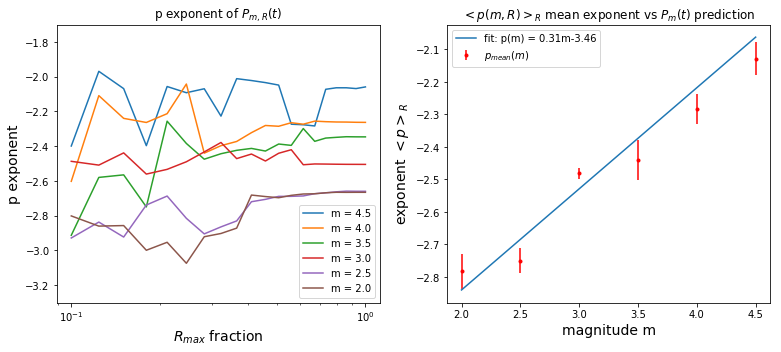

In [49]:
Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
for i in range(1,len(ms)+1):
    #plt.errorbar(Rs, Ps[-i], yerr = P_errors[-i], label = 'm = {}'.format(ms[-i]))
    ax1.plot(Rs, Ps[-i], label = 'm = {}'.format(ms[-i]))
ax1.legend(loc = 'lower right')
ax1.set_title('p exponent of $P_{m,R}(t)$')
ax1.set_xlabel('$R_{max}$ fraction', fontsize = 14)
ax1.set_ylabel('p exponent', fontsize = 14)
ax1.set_ylim(-3.3,-1.7)
#log scale can be useful because the P(r) distribution isn't uniform
ax1.set_xscale('log')

ax2.errorbar(ms, Ps.mean(axis = 1), yerr = Ps.std(axis = 1)/np.sqrt(len(ms)), fmt = 'r.', label = '$p_{mean}(m)$')
ax2.plot(ms, intercept+slope*ms, label = 'fit: p(m) = %.2fm%.2f'%(slope,intercept))
ax2.set_title('$<p(m,R)>_R$ mean exponent vs $P_{m}(t)$ prediction')
ax2.set_ylabel('exponent $<p>_R$', fontsize = 14)
ax2.set_xlabel('magnitude m', fontsize = 14)
ax2.legend()

plt.tight_layout()
plt.show()


# 5 - Scaling properties
Eventually note if, from the analysis of the previous points, there emerges a scaling picture. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?

## 5.1 - Time scaling with magnitude
First of all we have seen that the exponent $p$ of $P_m(t)$ is linear in m: $p(m) = \alpha + m\beta$

This mean that we can write:  

$P_m(t) = At^{p(m)} = At^{\alpha + m\beta} = P_0(t)t^{m\beta}$

Thus, through the scaling $t_w \rightarrow t_w^{-m\beta}t_w$ we should get the same distribution for the waiting time of events of magnitude > m.